# Diabetic Retinopathy: Image Classification with Vision Transformer

This Jupyter Notebook contains our solution of classifying five stages of Diabetic Retinopathy using a transformer architecture.

Submitted by:

* Lara Noe (217461)
* Hiroya Taguchi ()

## Library Imports

In [1]:
import os
import cv2
import random
import evaluate
import torch
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2, Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import load_dataset, load_metric
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

c:\users\laran\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.1+cpu


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preparation

## Loading Datasets from Directory

In [5]:
train_dir = '../DR_data_cropped_classes/train'
test_dir = '../DR_data_cropped_classes/test'

In [6]:
hug_train_ds = load_dataset(train_dir)
hug_test_ds = load_dataset(test_dir)

Resolving data files: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<?, ?it/s]


### Split training data into train and validation sets

In [7]:
hug_train_ds = hug_train_ds['train'].train_test_split(test_size=0.2)

In [8]:
hug_train_ds 

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3264
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 816
    })
})

We split the train dataset into two parts at this point, using 80% for training and 20% for validation. Due to the way that the datasets are defined, the validation subset is called 'test' here. However, to avoid confusion, we rename it during the following data preprocessing steps.

### Some sample images from the train dataset

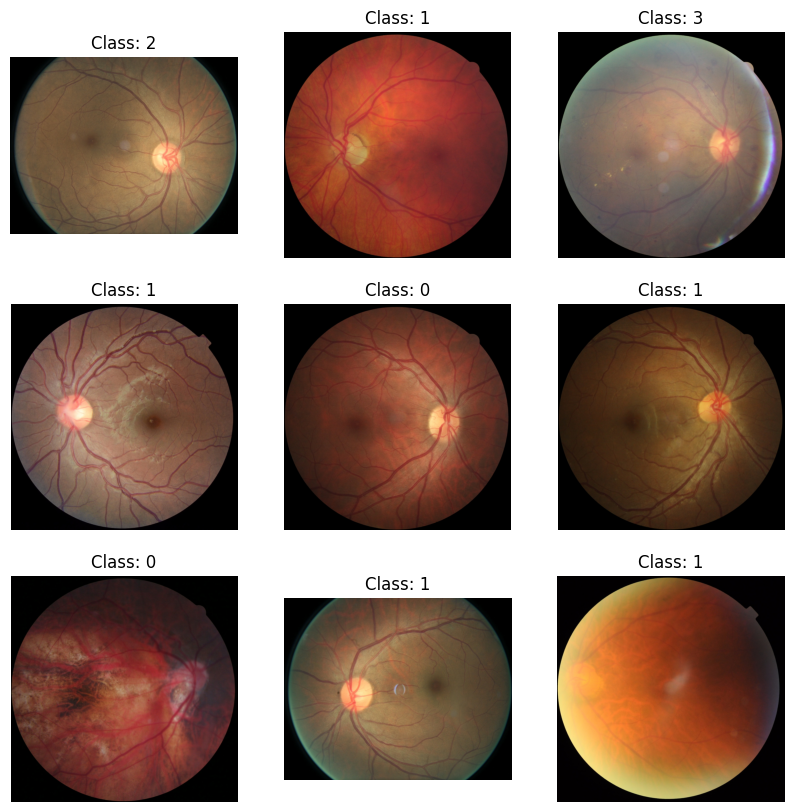

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    image = hug_train_ds['train'][i]["image"]
    label = hug_train_ds['train'][i]["label"]
    axes[i // 3, i % 3].imshow(image)
    axes[i // 3, i % 3].set_title(f"Class: {label}")
    axes[i // 3, i % 3].axis("off")

plt.show()

## Image Preprocessing

In [10]:
model_name_or_path = 'facebook/deit-tiny-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Define Data Augmentation

In [11]:
data_augmentation = Compose(
    [
        v2.ColorJitter(brightness=(0.7, 1.5), contrast=(0.9, 1.2), saturation= 0.1, hue=0.15), #brightness, contrast, saturation, hue
        v2.RandomRotation(20),
        v2.RandomHorizontalFlip(),
    ]
)

### Examples of augmented images from training dataset

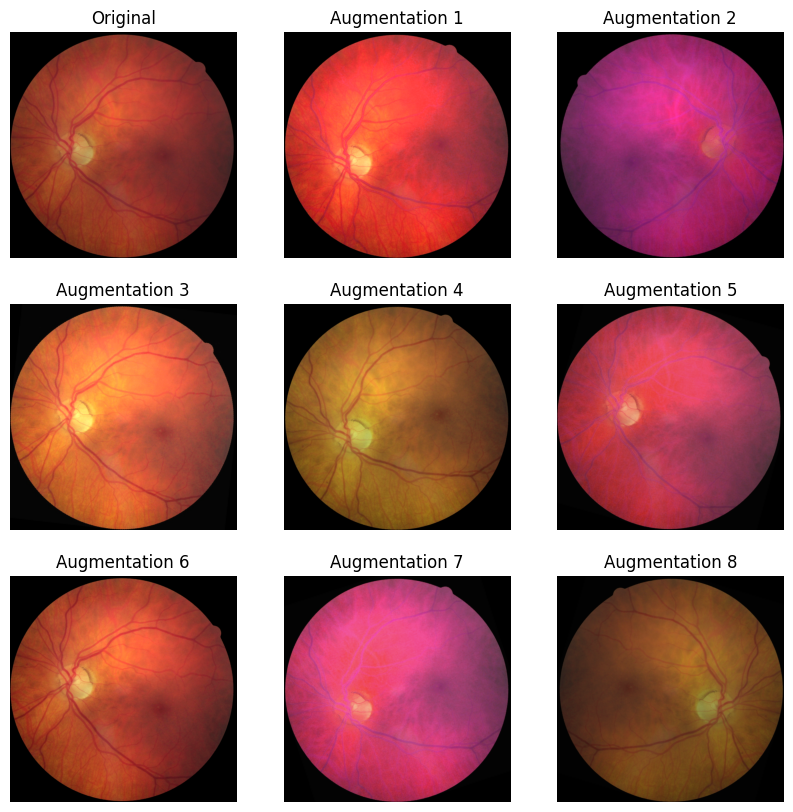

In [12]:
def apply_augmentations(img):
    augmented_images = [data_augmentation(img.convert("RGB")) for _ in range(9)]
    return augmented_images

example_image = hug_train_ds['train'][1]['image']

# Apply augmentations
augmented_images = apply_augmentations(example_image)

# Display the original and augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Display augmented images
for i, augmented_image in enumerate(augmented_images):
    axes[i // 3, i % 3].imshow(augmented_image)
    axes[i // 3, i % 3].set_title(f"Augmentation {i}")
    axes[i // 3, i % 3].axis("off")

# Display the original image
axes[0, 0].imshow(example_image)
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")

plt.show()

### Preprocess Datasets

The train dataset is augmented and preprocessed to turn the images into pixel values.

In [13]:
def train_transform(dataset):
    images = [data_augmentation(img.convert("RGB")) for img in dataset["image"]] # applying data augmentation
    inputs = processor(images, return_tensors='pt') # turn images into pixel values

    inputs['labels'] = dataset['label']
    return inputs

The validation dataset is simply turned into pixel values without applying data augmentation.

In [14]:
def val_transform(dataset):
    inputs = processor([x for x in dataset['image']], return_tensors='pt') # turning images into pixel values
    
    inputs['labels'] = dataset['label']
    return inputs

In [15]:
# applying preprocessing functions 'on-the-fly'
prepared_train_ds = hug_train_ds['train'].with_transform(train_transform)
prepared_val_ds = hug_train_ds['test'].with_transform(val_transform)
prepared_test_ds = hug_test_ds['train'].with_transform(val_transform)

# Model Preparation

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [17]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    class_probs = logits[0]
    predictions = np.argmax(class_probs, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Model Selection

In [18]:
labels = hug_train_ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    ignore_mismatched_sizes=True,
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}, 
    output_attentions = True, 
    return_dict = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training the Model

## Define Training Settings

In [19]:
training_args = TrainingArguments(
    output_dir="trained_vit_model",
    overwrite_output_dir = True,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    logging_first_step = True,
    warmup_ratio=0.1,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

## Training

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_val_ds,
    tokenizer=processor,
)

In [21]:
init_time = datetime.datetime.now()
train_results = trainer.train()

required_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(required_time)}\n') 


Required time:  2:01:03.217053



## Save trained model and training metrics locally

In [22]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        10.0
  total_flos               = 151698418GF
  train_loss               =      1.3097
  train_runtime            =  2:01:02.94
  train_samples_per_second =       4.494
  train_steps_per_second   =       0.562


# Model Evaluation

## Evaluation on Test Set

In [23]:
metrics = trainer.evaluate(prepared_test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.446
  eval_loss               =     1.2162
  eval_runtime            = 0:00:45.95
  eval_samples_per_second =      10.88
  eval_steps_per_second   =      1.371


## Load trained Model and Training History

In [24]:
trained_model = ViTForImageClassification.from_pretrained('trained_vit_model')

In [25]:
loaded_history = pd.read_json('trained_vit_model/trainer_state.json')
loaded_history = pd.json_normalize(loaded_history.log_history)
loaded_history

epoch  learning_rate    loss  step  eval_accuracy  eval_loss  \
0    0.00   2.450980e-08  1.6094     1            NaN        NaN   
1    1.00            NaN     NaN   408       0.328431   1.495060   
2    1.23   9.749455e-06  1.5630   500            NaN        NaN   
3    2.00            NaN     NaN   816       0.350490   1.393711   
4    2.45   8.387800e-06  1.4063  1000            NaN        NaN   
5    3.00            NaN     NaN  1224       0.398284   1.312252   
6    3.68   7.026144e-06  1.3408  1500            NaN        NaN   
7    4.00            NaN     NaN  1632       0.420343   1.254282   
8    4.90   5.664488e-06  1.2890  2000            NaN        NaN   
9    5.00            NaN     NaN  2040       0.454657   1.249833   
10   6.00            NaN     NaN  2448       0.465686   1.211742   
11   6.13   4.302832e-06  1.2509  2500            NaN        NaN   
12   7.00            NaN     NaN  2856       0.454657   1.200879   
13   7.35   2.941176e-06  1.2409  3000            NaN        NaN   
14   8.00            NaN     NaN  3264       0.449755   1.216128   
15   8.58   1.579521e-06  1.2137  3500            NaN        NaN   
16   9.00            NaN     NaN  3672       0.476716   1.196630   
17   9.80   2.178649e-07  1.1927  4000            NaN        NaN   
18  10.00            NaN     NaN  4080       0.484069   1.188401   
19  10.00            NaN     NaN  4080            NaN        NaN   

    eval_runtime  eval_samples_per_second  eval_steps_per_second  \
0            NaN                      NaN                    NaN   
1        90.5761                    9.009                  1.126   
2            NaN                      NaN                    NaN   
3        90.5393                    9.013                  1.127   
4            NaN                      NaN                    NaN   
5        90.7214                    8.995                  1.124   
6            NaN                      NaN                    NaN   
7        90.1178                    9.055                  1.132   
8            NaN                      NaN                    NaN   
9        90.4257                    9.024                  1.128   
10       91.2134                    8.946                  1.118   
11           NaN                      NaN                    NaN   
12       90.4725                    9.019                  1.127   
13           NaN                      NaN                    NaN   
14       90.8432                    8.983                  1.123   
15           NaN                      NaN                    NaN   
16       90.7677                    8.990                  1.124   
17           NaN                      NaN                    NaN   
18       91.8705                    8.882                  1.110   
19           NaN                      NaN                    NaN   

      total_flos  train_loss  train_runtime  train_samples_per_second  \
0            NaN         NaN            NaN                       NaN   
1            NaN         NaN            NaN                       NaN   
2            NaN         NaN            NaN                       NaN   
3            NaN         NaN            NaN                       NaN   
4            NaN         NaN            NaN                       NaN   
5            NaN         NaN            NaN                       NaN   
6            NaN         NaN            NaN                       NaN   
7            NaN         NaN            NaN                       NaN   
8            NaN         NaN            NaN                       NaN   
9            NaN         NaN            NaN                       NaN   
10           NaN         NaN            NaN                       NaN   
11           NaN         NaN            NaN                       NaN   
12           NaN         NaN            NaN                       NaN   
13           NaN         NaN            NaN                       NaN   
14           NaN         NaN            NaN        

## Accuracy and Loss Plots

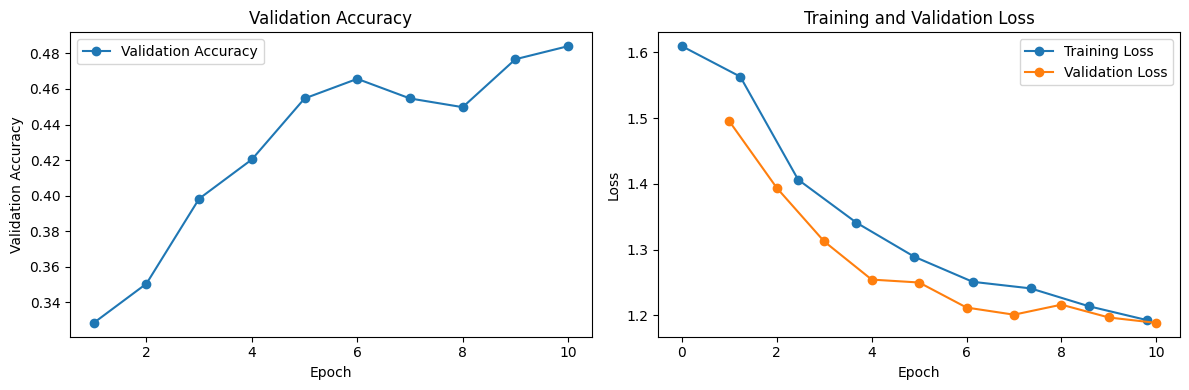

In [26]:
# Drop rows with NaN values in eval_loss and eval_accuracy
log_history_cleaned = loaded_history.dropna(subset=['eval_loss', 'eval_accuracy'])
log_history_cleaned_1 = loaded_history.dropna(subset=['loss'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(log_history_cleaned['epoch'], log_history_cleaned['eval_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy')
axes[0].legend()

# Plot training and validation loss
axes[1].plot(log_history_cleaned_1['epoch'], log_history_cleaned_1['loss'], label='Training Loss', marker='o')
axes[1].plot(log_history_cleaned['epoch'], log_history_cleaned['eval_loss'], label='Validation Loss', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

## Confusion Matrix

In [27]:
# get transformed test dataset
zero_loader = DataLoader(prepared_test_ds, batch_size=16)
zero_pred = []
# zero-shot prediction
for batch in tqdm(zero_loader):
    with torch.no_grad():
        logits = trained_model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]
zero_true = [labels[i] for i in hug_test_ds['train']['label']]

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:25<00:00,  1.23it/s]


Confusion Matrix


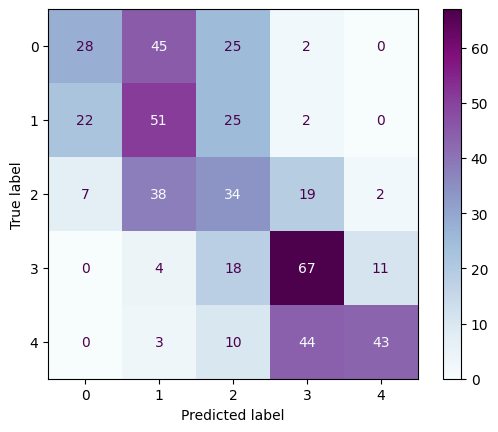

Accuracy: 44.60 %


In [28]:
# plot confusion matrix
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.BuPu)
plt.show()
# metrics
print(f'Accuracy: {100 * accuracy_score(zero_true, zero_pred):.2f} %')

Overall, it is clear to see that the model still has some problems differentiating between classes that are close together. The confusion matrix above visualizes that especially class 3 and 4 as well as class 0 and 1 get often confused for eachother. This result is completely plausible, since the class numbers directly refer to the progression stages of diabetic rethinopathy. Images of early stages (0 and 1) are visually very similar but completely different from later stages (3 and 4). This is a good result after only 4 training epochs and shows that the model learned to differentiate between both extremes of the diabetic retinopathy spectrum. With more time for training, it could pick up on more details between the more similar stages and eventually be able to classify all different stages more accuratly. 

## Examples of misclassified images

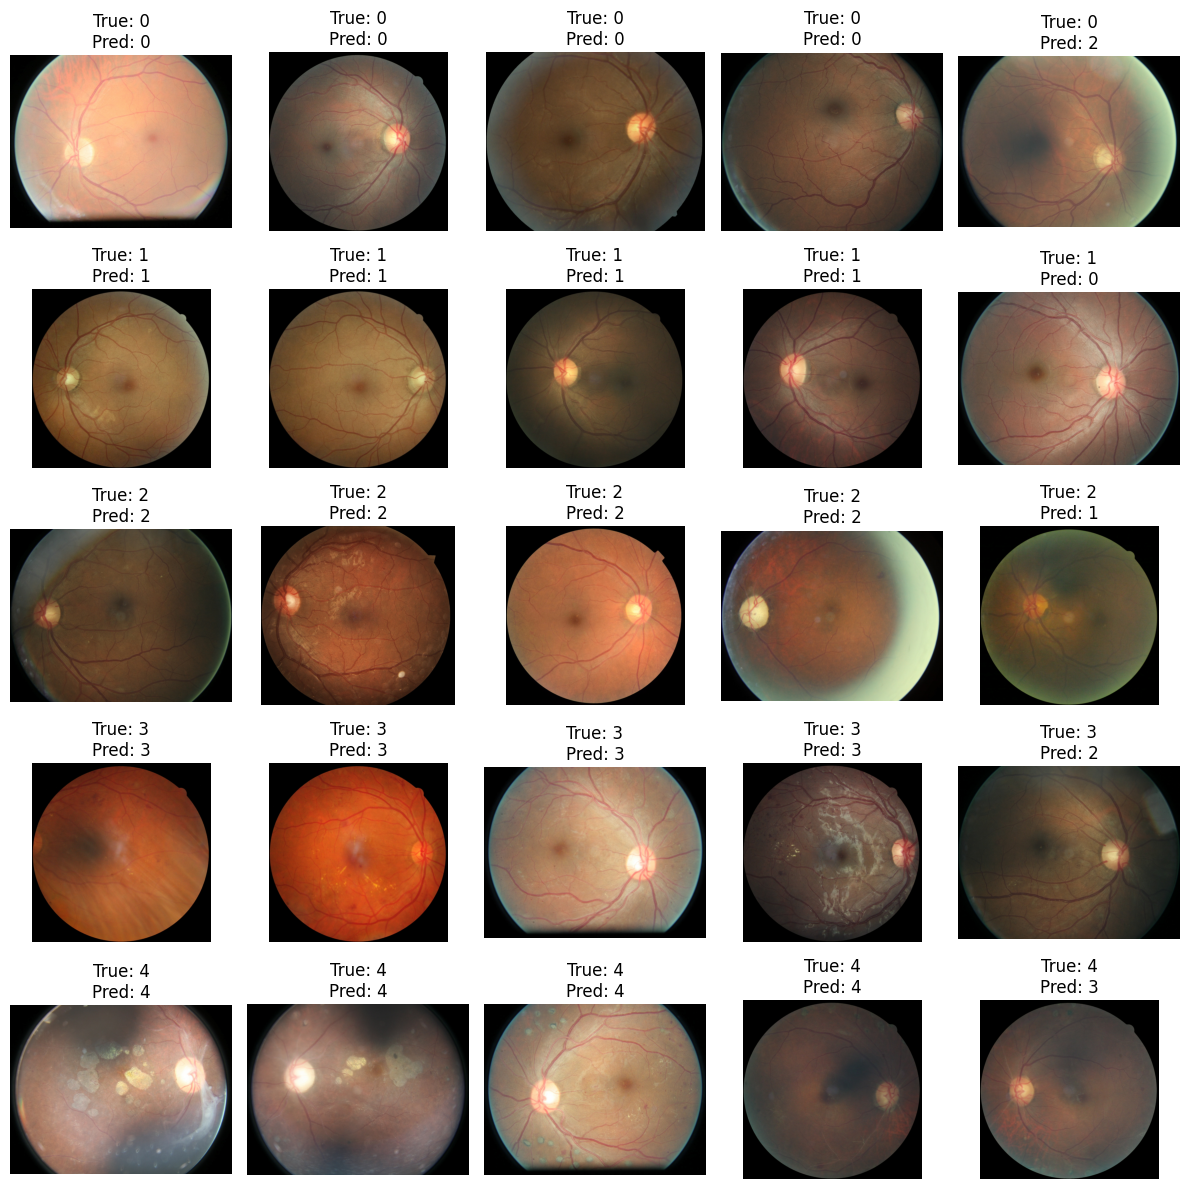

In [29]:
correctly_classified_indices = [idx for idx, (true, pred) in enumerate(zip(zero_true, zero_pred)) if true == pred]
misclassified_indices = [idx for idx, (true, pred) in enumerate(zip(zero_true, zero_pred)) if true != pred]

# Display examples for each class in a 5x5 grid
unique_misclassified_classes = sorted(set(zero_true[idx] for idx in misclassified_indices))
fig, axes = plt.subplots(len(unique_misclassified_classes), 5, figsize=(12,12))

for i, true_class in enumerate(unique_misclassified_classes):
    
    # Display four correctly classified examples
    correctly_classified_indices_for_class = [
        idx for idx in correctly_classified_indices if zero_true[idx] == true_class
    ][:4]
    for j, idx in enumerate(correctly_classified_indices_for_class):
        true_example = hug_test_ds['train'][idx]['image']
        axes[i, j].imshow(true_example)
        axes[i, j].set_title(f'True: {true_class}\nPred: {true_class}')
        axes[i, j].axis('off')

    # Display one misclassified example
    misclassified_idx_for_class = next(idx for idx in misclassified_indices if zero_true[idx] == true_class)
    true_label = zero_true[misclassified_idx_for_class]
    pred_label = zero_pred[misclassified_idx_for_class]
    misclassified_example = hug_test_ds['train'][misclassified_idx_for_class]['image']
    axes[i, 4].imshow(misclassified_example)
    axes[i, 4].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

### Possible Reasons for Misclassification 

|Class|Predicted Class|Possible Reason|
|:-----:|:------:|----|
|0|1|ufghjköölhgkhjlö|
|1|0|hsdfskjhdjf|
|2|1|puiz9uoipü+|
|3|4|puiz9uoipü+|
|4|3|puiz9uoipü+|

## Attention Maps

### Attention map functions

In [30]:
def get_attention_map(model, img, get_mask=False):
    inputs = processor(img, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits 
        att_mat = model(**inputs).attentions

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    
    result = cv2.resize(mask / mask.max(), img.size)
         
    mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    masked_result = (mask * img).astype("uint8")
    
    return result, masked_result

In [31]:
def plot_attention_map(original_img, att_map, att_mask, class_name):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 12))
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax1.set_title(f'Original Image\n(Class {class_name})')
    ax2.set_title('Attention Map Last Layer')
    ax3.set_title('Masked Attention Image')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)
    _ = ax3.imshow(att_mask)

### Attention maps for some sample images  

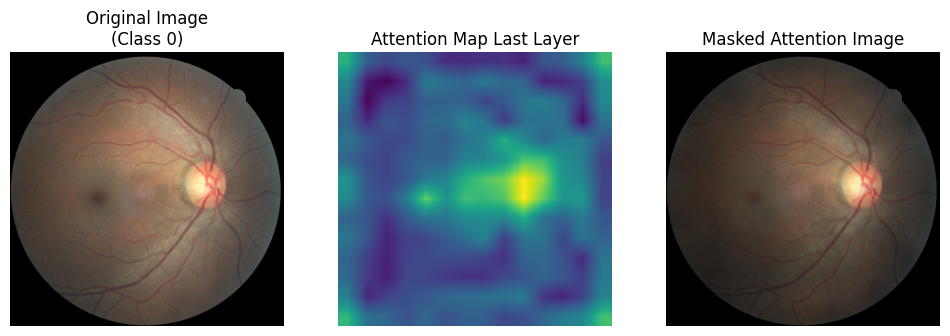

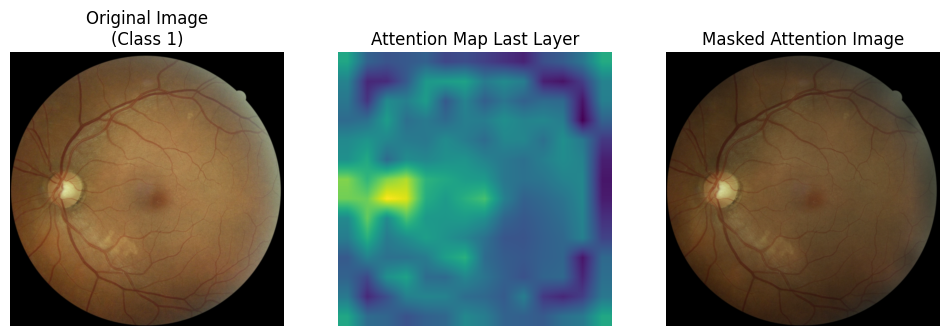

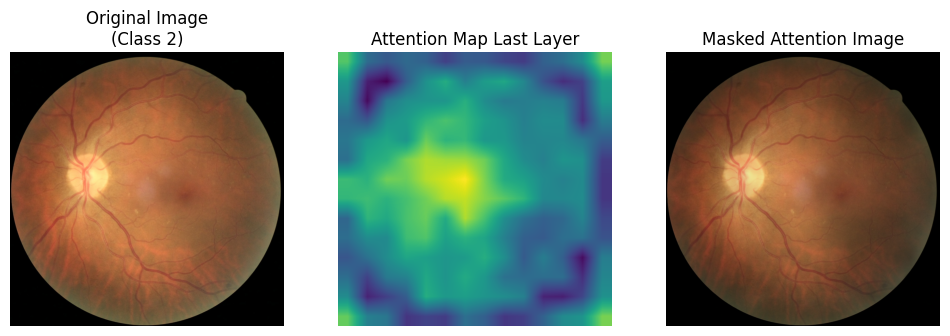

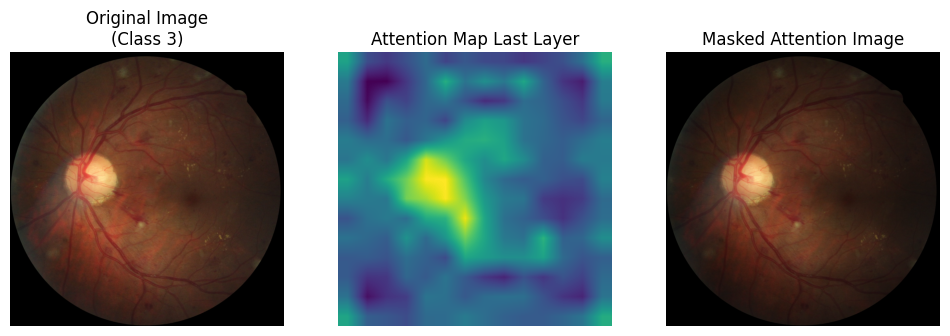

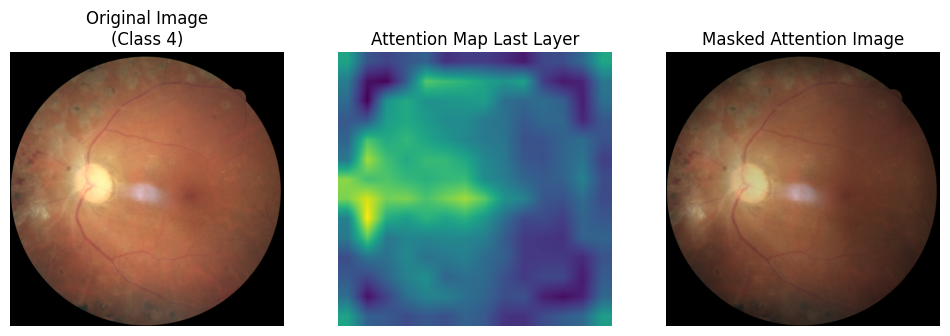

In [32]:
samples = [
    "../DR_data_cropped_classes/test/0/1012_right.jpeg",
    "../DR_data_cropped_classes/test/1/1020_left.jpeg",
    "../DR_data_cropped_classes/test/2/1552_left.jpeg",
    "../DR_data_cropped_classes/test/3/1639_left.jpeg",
    "../DR_data_cropped_classes/test/4/294_left.jpeg"
]
for i, img_path in enumerate(samples):
    img = Image.open(img_path)
    class_name = os.path.basename(os.path.dirname(img_path))
    result, masked_result = get_attention_map(trained_model, img, True)
    plot_attention_map(img, result, masked_result, class_name)

### Discussion of focus on right features

|Class|Does the Model focus on the right features?|
|:-----:|----|
|0|ufghjköölhgkhjlö|
|1|hsdfskjhdjf|
|2|puiz9uoipü+|
|3|puiz9uoipü+|
|4|Yes, in this case the model focusses accurately on the changes |

# References

[Fine-Tune ViT for Image Classification with 🤗 Transformers](https://huggingface.co/blog/fine-tune-vit)

[Hugging Face: Preprocessing data](https://huggingface.co/docs/transformers/v4.36.1/en/preprocessing#computer-vision)

[Classification Example (Kaggle)](https://www.kaggle.com/code/tiansztianszs/google-vit-base-patch16-224)

[Confusion Matrix](https://medium.com/data-folks-indonesia/exploring-visual-transformers-vit-with-huggingface-8cdda82920a0)

[Attention Maps](https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map#Load-ViT-Model)